In [2]:
import clip
import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import torch

from io import BytesIO
from IPython.display import Image, display
from PIL import Image as PILImage
from tqdm import tqdm

In [11]:
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_seconds = total_frames / frame_rate
    target_frame_count = int(total_seconds)
    target_frame_index = 0
    for i in range(target_frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        target_frame_index += int(frame_rate)
    cap.release()
    return frames


def generate_embedding(frame):
    frame_tensor = preprocess(PILImage.fromarray(frame)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(frame_tensor).cpu().numpy()
    print(type(embedding), embedding.shape)
    return embedding[0]


def store_frame_embedding_and_image(video_path):
    frames = extract_frames(video_path)
    data = [
        (i+1, generate_embedding(frame), frame)
        for i, frame in enumerate(tqdm(
            frames,
            desc = "Processing frames",
            bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]")
        )
    ]
    return pd.DataFrame(data, columns = ["frame_number", "embedding_data", 'frame_data'])


def calculate_similarity(query_embedding, df):
    # Convert the query embedding to a tensor
    query_tensor = torch.tensor(query_embedding, dtype = torch.float32).to(device)

    # Convert the list of embeddings to a numpy array
    embeddings_np = np.array(df["embedding_data"].tolist())

    # Create a tensor from the numpy array
    embeddings_tensor = torch.tensor(embeddings_np, dtype = torch.float32).to(device)

    # Compute similarities using matrix multiplication
    similarities = torch.mm(embeddings_tensor, query_tensor.unsqueeze(1)).squeeze().tolist()
    return similarities


def encode_image_query(image):
    # Preprocess the image and add batch dimension
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Extract features using the model
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
    
    # Convert features to NumPy array and flatten
    return image_features.cpu().numpy().flatten()


def plot_frames(frames):
    num_frames = len(frames)
    fig, axes = plt.subplots(1, num_frames, figsize = (15, 5))
    
    for ax, frame_data in zip(axes, frames):
        ax.imshow(frame_data)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device = device)

In [13]:
list_path_videos = os.listdir('videos')
list_path_videos.remove('dubl.mp4')

df = store_frame_embedding_and_image(os.path.join('videos', list_path_videos[0]))
# for path_video in list_path_videos[1:]:
#     path_video = os.path.join('videos', path_video)
#     tmp_df = store_frame_embedding_and_image(path_video)
#     df = pd.concat([df, tmp_df], axis=0, join='inner')

# Normalise
df["embedding_data"] = df["embedding_data"].apply(
    lambda vec: vec / np.linalg.norm(vec)
)
df.reset_index(drop=True, inplace=True)

df.head(1)

Processing frames:  27%|██████▊                  | 3/11 [00:00<00:00, 10.30it/s]

<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)


Processing frames:  45%|███████████▎             | 5/11 [00:00<00:00, 10.51it/s]

<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)


Processing frames:  82%|████████████████████▍    | 9/11 [00:00<00:00, 11.15it/s]

<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)


Processing frames: 100%|████████████████████████| 11/11 [00:01<00:00, 10.55it/s]

<class 'numpy.ndarray'> (1, 512)
<class 'numpy.ndarray'> (1, 512)


,frame_number,embedding_data,frame_data
0,1,"[-0.038103107, 0.00211355, 0.0041977726, 0.028...","[[[82, 99, 115], [76, 93, 109], [76, 93, 109],..."


In [69]:
# Normalise
df["embedding_data"] = df["embedding_data"].apply(
    lambda vec: vec / np.linalg.norm(vec)
)

Загрузить дубликат

In [75]:
video = widgets.Video.from_file(
    'videos/dubl.mp4',
    loop = False
)

display(video)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x1e\x1cmoov...', loop='False')

In [70]:
df_test = store_frame_embedding_and_image('videos/dubl.mp4')

# Normalise
df_test["embedding_data"] = df_test["embedding_data"].apply(
    lambda vec: vec / np.linalg.norm(vec)
)

Processing frames: 100%|█████████████████████████████████████████| 7/7 [00:00<00:00,  7.13it/s]


Top 5 best matches:
 frame_number  image_similarity
            1          0.996914
            2          0.966137
            6          0.930508
            5          0.902733
            7          0.899931


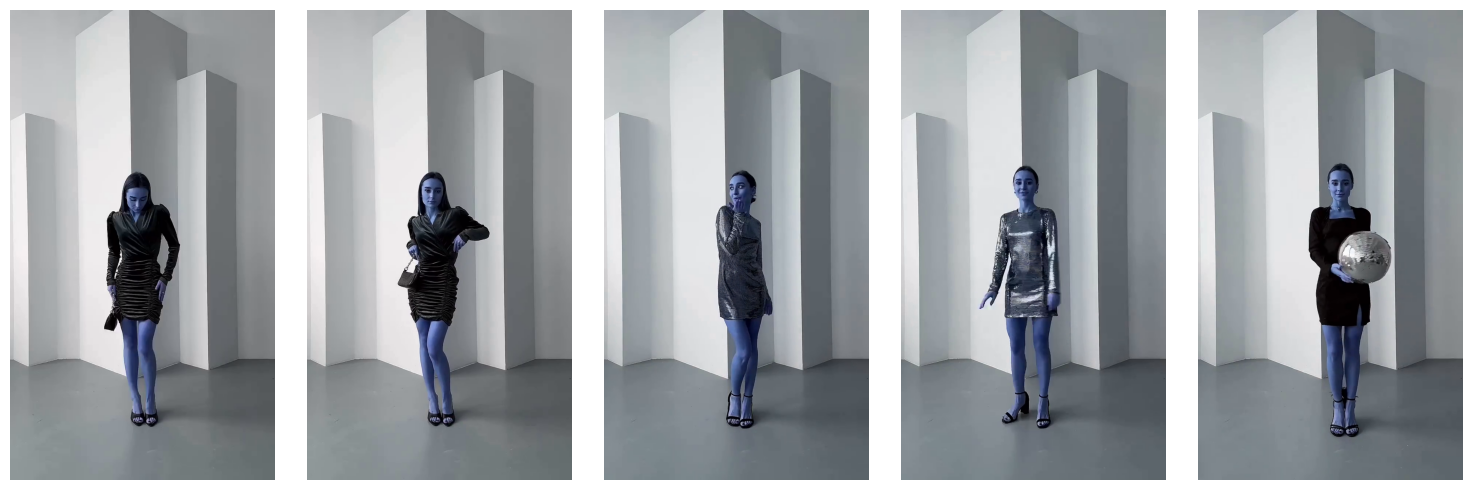

Top 5 best matches:
 frame_number  image_similarity
            2          0.887504
            1          0.845168
            4          0.811309
            6          0.803878
            7          0.790792


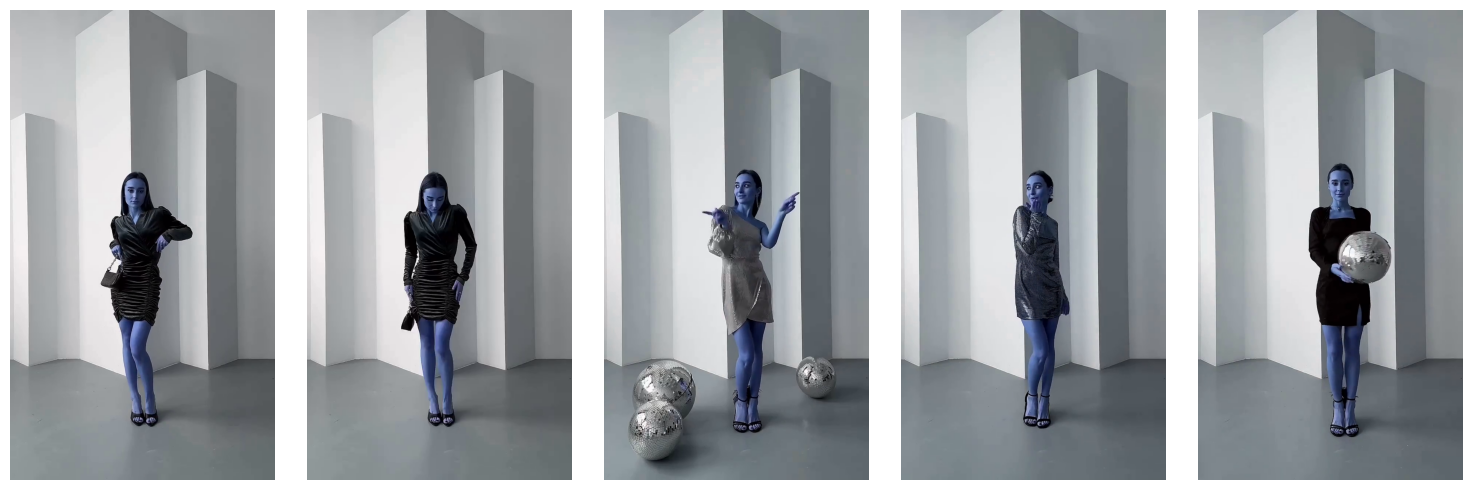

Top 5 best matches:
 frame_number  image_similarity
            3          0.965625
            2          0.848668
            1          0.847732
            7          0.801628
            5          0.794864


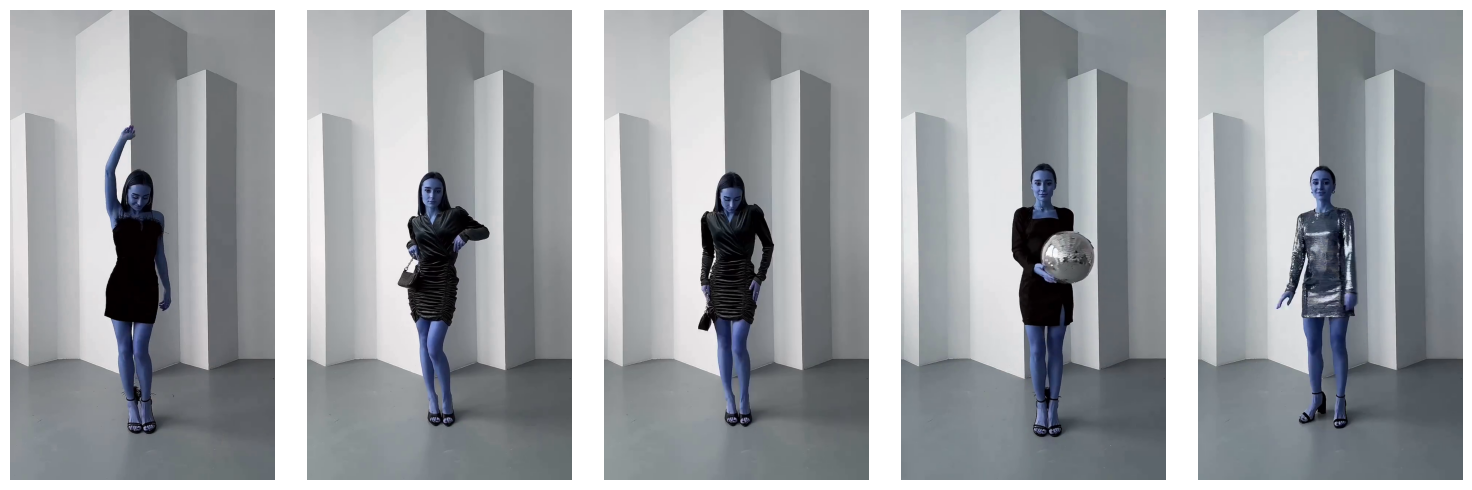

Top 5 best matches:
 frame_number  image_similarity
            4          0.908914
            2          0.854148
            6          0.831593
            1          0.819977
            5          0.818160


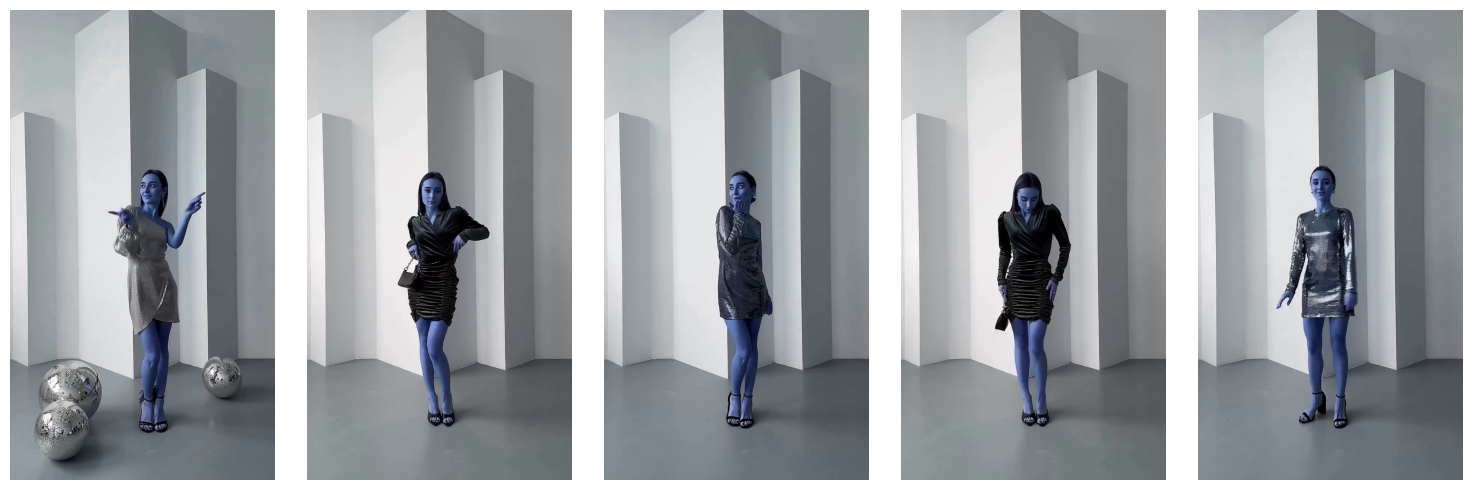

Top 5 best matches:
 frame_number  image_similarity
            5          0.978204
            6          0.909182
            2          0.901409
            1          0.894147
            4          0.882236


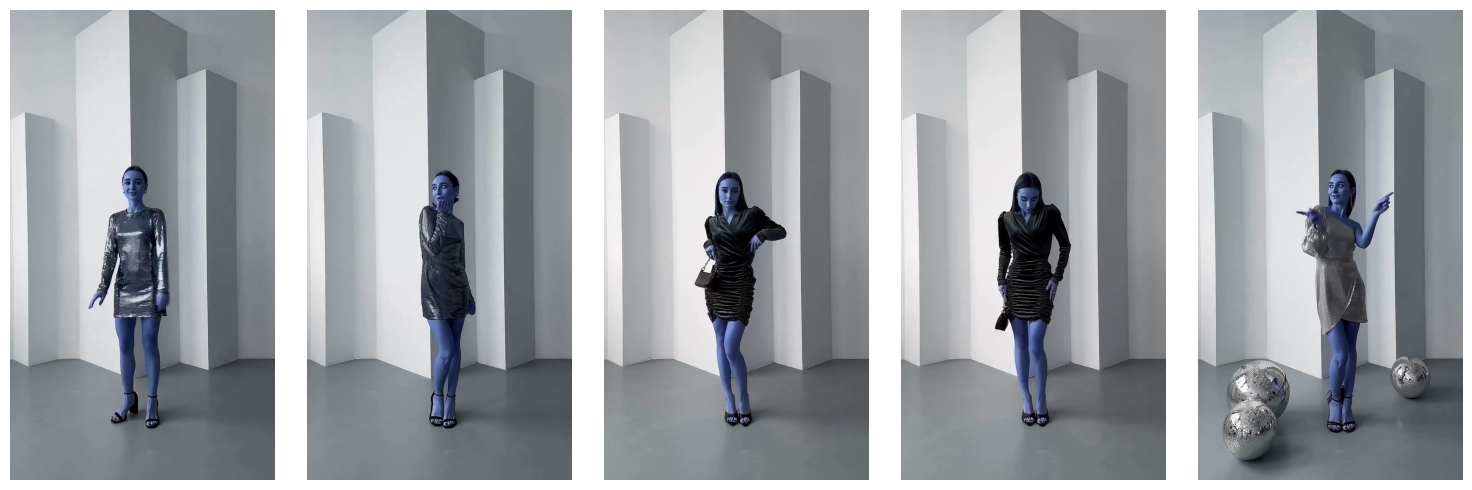

Top 5 best matches:
 frame_number  image_similarity
            6          0.925492
            2          0.881233
            5          0.865490
            4          0.859908
            1          0.858212


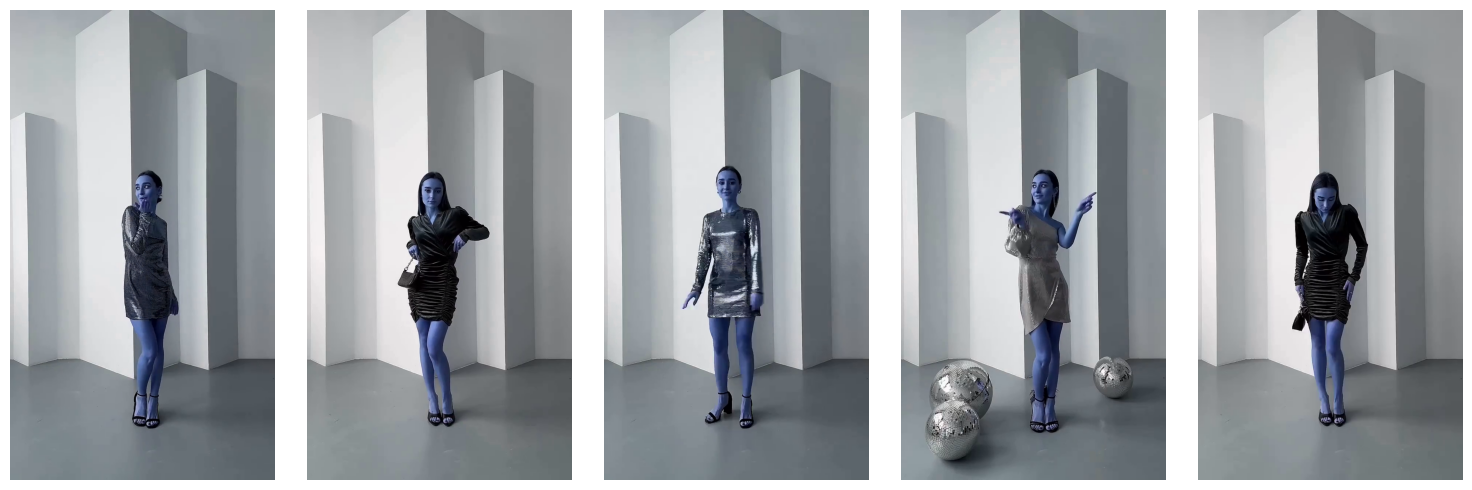

Top 5 best matches:
 frame_number  image_similarity
            7          0.930411
            2          0.865957
            6          0.845498
            1          0.839423
            5          0.838455


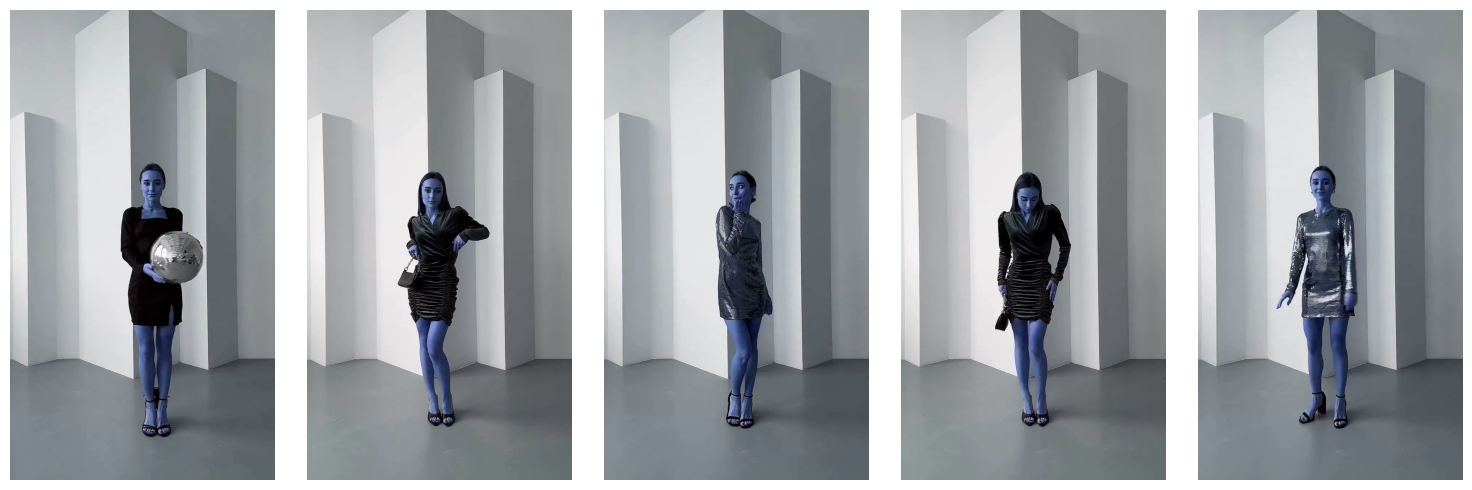

In [71]:
for embedding in df_test.embedding_data:
    image_similarities = calculate_similarity(embedding, df)
    df["image_similarity"] = image_similarities

    top_image_matches = df.nlargest(5, "image_similarity")
    # print(top_image_matches)

    print("Top 5 best matches:")
    print(top_image_matches[["frame_number", "image_similarity"]].to_string(index = False))

    # Collect frame data and numbers for the top image matches
    top_image_matches_indices = top_image_matches.index.tolist()
    # print(top_image_matches_indices)
    # break
    frames = [df.at[index, "frame_data"] for index in top_image_matches_indices]
    # frame_numbers = [df.at[index, "frame_number"] for index in top_image_matches_indices]
    
    # Plot the frames
    # print(frames)
    # print()
    # print(frame_numbers)
    plot_frames(frames)
    break

In [76]:
df.head(1)

,frame_number,embedding_data,frame_data,image_similarity
0,1,"[-0.038103107, 0.00211355, 0.0041977726, 0.028...","[[[82, 99, 115], [76, 93, 109], [76, 93, 109],...",0.552671
